# Analyse de qualité des données — Produits alimentaires vendus au Canada (Open Food Facts)
**Data Analyst**    
**Projet :** Application web d’exploration et de comparaison nutritionnelle (Canada)

## 1. Chargement des données

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configuration des graphiques (optionnel)
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Chemin robuste (fonctionne localement + dans certains environnements)
DATA_PATH = Path("data/bronze/canada_sample.csv")

df = pd.read_csv(DATA_PATH, low_memory=False)

print("📊 Informations sur le dataset")
print(f"• Chemin: {DATA_PATH}")
print(f"• Dimensions: {df.shape[0]} lignes × {df.shape[1]} colonnes")
print(f"• Taille mémoire: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")



display(df.head())
display(df.dtypes.head(25))

ModuleNotFoundError: No module named 'seaborn'

## 2) Champs cruciaux (alignés avec les objectifs du projet)
Ces champs servent à l'identification produit, aux comparaisons par catégories,
à l'analyse Nutri-Score et aux nutriments coeur (énergie, sucres, gras, sel).

In [1]:
CHAMPS_CRUCIAUX = {
    # Identification
    "code": "Code-barres / identifiant produit (clé primaire logique)",
    "product_name": "Nom du produit",
    "brands": "Marque(s)",
    "labels_tags": "Labels et certifications normalisés (bio, vegan, halal, etc.)",


    # Catégorisation
    "categories": "Catégories (texte libre)",
    "categories_tags": "Catégories (tags normalisés)",

    # Nutrition coeur (comparaison & analytics)
    "nutriscore_grade": "Nutri-Score (A–E)",
    "energy_100g": "Énergie (kJ/100g)",
    "energy-kcal_100g": "Énergie (kcal/100g)",
    "sugars_100g": "Sucres (g/100g)",
    "fat_100g": "Matières grasses (g/100g)",
    "saturated-fat_100g": "Acides gras saturés (g/100g)",
    "salt_100g": "Sel (g/100g)",
    "fiber_100g": "Fibres (g/100g)",
    "proteins_100g": "Protéines (g/100g)",

    # Ingrédients (exploration & information utilisateur)
    "ingredients_text": "Liste des ingrédients (texte brut)",

    # Autres (utile mais non essentiel)
    "countries": "Pays de vente (texte)",
    "countries_tags": "Pays (tags normalisés)",
    "nova_group": "Groupe NOVA (1–4)",
    "image_small_url": "URL image (petite, rapide pour l’affichage)",
    "image_url": "URL image (taille normale)"
}
# Version simple pour copier-coller
print("CHAMPS_CRUCIAUX = {")
for champ, description in CHAMPS_CRUCIAUX.items():
    print(f'    "{champ}": "{description}",')
print("}")



CHAMPS_CRUCIAUX = {
    "code": "Code-barres / identifiant produit (clé primaire logique)",
    "product_name": "Nom du produit",
    "brands": "Marque(s)",
    "labels_tags": "Labels et certifications normalisés (bio, vegan, halal, etc.)",
    "categories": "Catégories (texte libre)",
    "categories_tags": "Catégories (tags normalisés)",
    "nutriscore_grade": "Nutri-Score (A–E)",
    "energy_100g": "Énergie (kJ/100g)",
    "energy-kcal_100g": "Énergie (kcal/100g)",
    "sugars_100g": "Sucres (g/100g)",
    "fat_100g": "Matières grasses (g/100g)",
    "saturated-fat_100g": "Acides gras saturés (g/100g)",
    "salt_100g": "Sel (g/100g)",
    "fiber_100g": "Fibres (g/100g)",
    "proteins_100g": "Protéines (g/100g)",
    "ingredients_text": "Liste des ingrédients (texte brut)",
    "countries": "Pays de vente (texte)",
    "countries_tags": "Pays (tags normalisés)",
    "nova_group": "Groupe NOVA (1–4)",
    "image_small_url": "URL image (petite, rapide pour l’affichage)",
    "image_

## 3) Standardisation minimale (pour obtenir des statistiques fiables)
Open Food Facts peut contenir des nombres stockés en texte. On convertit les nutriments en numérique
et on normalise le Nutri-Score.

In [ ]:
# Conversion en numérique (sinon les stats peuvent être fausses si le dtype est "object")
CHAMPS_NUMERIQUES = [
    "energy_100g", "energy-kcal_100g",
    "sugars_100g", "fat_100g", "saturated-fat_100g",
    "salt_100g", "fiber_100g", "proteins_100g"
]
for c in CHAMPS_NUMERIQUES:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

# Normalisation du Nutri-Score: A–E → a–e, tout le reste → NaN
if "nutriscore_grade" in df.columns:
    df["nutriscore_grade"] = df["nutriscore_grade"].astype(str).str.strip().str.lower()
    df.loc[~df["nutriscore_grade"].isin(list("abcde")), "nutriscore_grade"] = np.nan

# Extraction d'une catégorie principale (premier tag) pour analyses "par catégorie"
if "categories_tags" in df.columns:
    df["categorie_principale"] = (
        df["categories_tags"].fillna("")
        .str.split(",").str[0]
        .str.replace("en:", "", regex=False)
    )
    df.loc[df["categorie_principale"].eq(""), "categorie_principale"] = "uncategorized"


## 4) Rapport de qualité (taux de remplissage, valeurs manquantes, stats de base)

In [ ]:
def priorite_depuis_remplissage(taux_remplissage: float) -> str:
    """Retourne une priorité simple selon le taux de remplissage (%) d'un champ."""
    if taux_remplissage < 50:
        return "HAUTE"
    if taux_remplissage < 80:
        return "MOYENNE"
    return "BASSE"

rapport_qualite = []
total = len(df)

for champ, description in CHAMPS_CRUCIAUX.items():
    if champ not in df.columns:
        rapport_qualite.append({
            "Champ": champ,
            "Description": description,
            "Type": "COLONNE_ABSENTE",
            "Remplissage_%": 0.0,
            "Nulls": total,
            "Statistiques": "COLONNE ABSENTE",
            "Priorité": "CRITIQUE",
        })
        continue

    non_null = df[champ].notna().sum()
    nulls = total - non_null
    taux = (non_null / total) * 100

    # Statistiques selon type
    if pd.api.types.is_numeric_dtype(df[champ]):
        s = df[champ].dropna()
        if len(s) > 0:
            stats = f"moy={s.mean():.2f}, écart-type={s.std():.2f}, min={s.min():.2f}, max={s.max():.2f}"
        else:
            stats = "aucune valeur numérique"
    else:
        nb_uniques = df[champ].nunique(dropna=True)
        top = df[champ].dropna().astype(str).value_counts().head(1)
        val_top = top.index[0] if len(top) else "N/A"
        stats = f"{nb_uniques} valeurs uniques, top='{val_top}'"

    rapport_qualite.append({
        "Champ": champ,
        "Description": description,
        "Type": str(df[champ].dtype),
        "Remplissage_%": round(taux, 2),
        "Nulls": int(nulls),
        "Statistiques": stats,
        "Priorité": priorite_depuis_remplissage(taux),
    })

report_df = pd.DataFrame(rapport_qualite)

print(" RAPPORT DE QUALITÉ — Champs cruciaux")
display(report_df.sort_values("Remplissage_%"))


 RAPPORT DE QUALITÉ — Champs cruciaux


,Champ,Description,Type,Remplissage_%,Nulls,Statistiques,Priorité
3,labels_tags,"Labels et certifications normalisés (bio, vega...",object,47.43,12612,"3484 valeurs uniques, top='en:no-gluten'",HAUTE
18,nova_group,Groupe NOVA (1–4),float64,51.79,11565,"moy=3.34, écart-type=1.02, min=1.00, max=4.00",MOYENNE
15,ingredients_text,Liste des ingrédients (texte brut),object,52.89,11301,"12098 valeurs uniques, top='Carbonated water, ...",MOYENNE
13,fiber_100g,Fibres (g/100g),float64,70.21,7146,"moy=3.14, écart-type=6.09, min=0.00, max=306.00",MOYENNE
2,brands,Marque(s),object,73.84,6276,"5969 valeurs uniques, top='Compliments'",MOYENNE
6,nutriscore_grade,Nutri-Score (A–E),object,85.09,3577,"5 valeurs uniques, top='e'",BASSE
12,salt_100g,Sel (g/100g),float64,91.13,2127,"moy=7.13, écart-type=629.64, min=0.00, max=925...",BASSE
11,saturated-fat_100g,Acides gras saturés (g/100g),float64,95.62,1050,"moy=4.71, écart-type=8.58, min=0.00, max=111.00",BASSE
9,sugars_100g,Sucres (g/100g),float64,96.53,833,"moy=13.71, écart-type=21.64, min=0.00, max=100...",BASSE
19,image_small_url,"URL image (petite, rapide pour l’affichage)",object,98.70,312,"23677 valeurs uniques, top='https://images.ope...",BASSE


### 4.1 Visualisations : taux de remplissage + distribution Nutri-Score


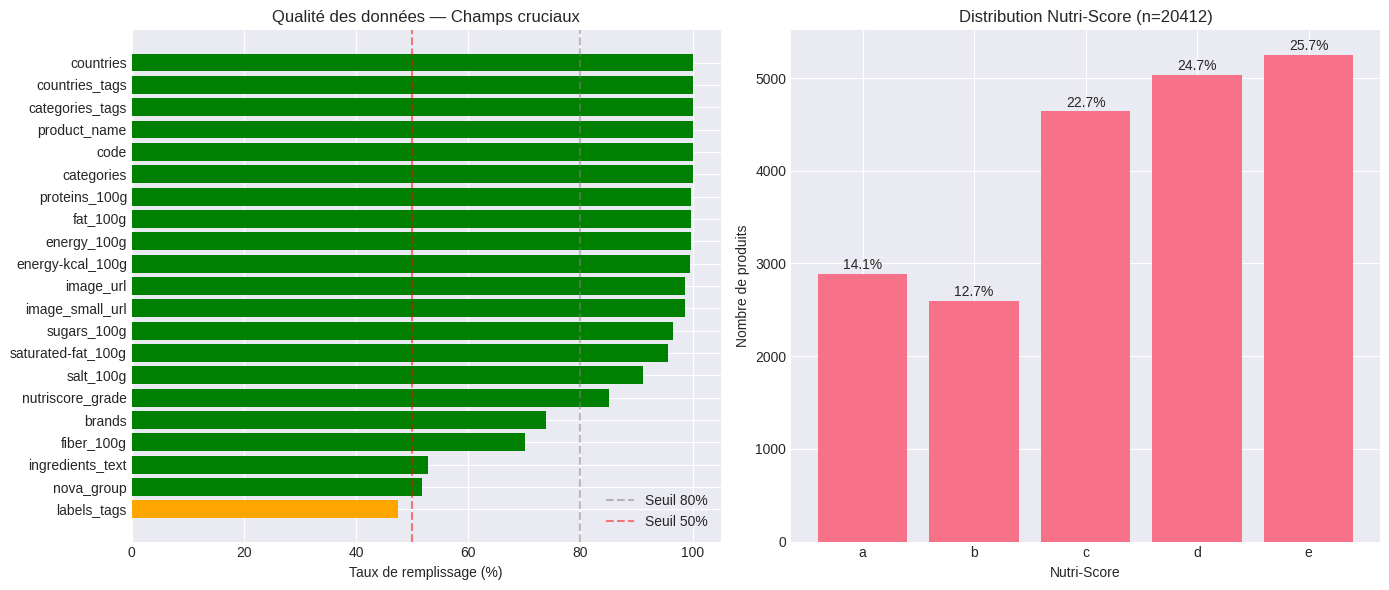

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1 : taux de remplissage
ax1 = axes[0]
rep_trie = report_df.sort_values("Remplissage_%", ascending=True)

def couleur_priorite(p):
    if p == "CRITIQUE":
        return "red"
    if p == "HAUTE":
        return "orange"
    return "green"

couleurs = [couleur_priorite(p) for p in rep_trie["Priorité"]]

ax1.barh(range(len(rep_trie)), rep_trie["Remplissage_%"], color=couleurs)
ax1.set_yticks(range(len(rep_trie)))
ax1.set_yticklabels(rep_trie["Champ"])
ax1.set_xlabel("Taux de remplissage (%)")
ax1.set_title("Qualité des données — Champs cruciaux")
ax1.axvline(x=80, color="gray", linestyle="--", alpha=0.5, label="Seuil 80%")
ax1.axvline(x=50, color="red", linestyle="--", alpha=0.5, label="Seuil 50%")
ax1.legend()

# Graphique 2 : distribution Nutri-Score
ax2 = axes[1]
if "nutriscore_grade" in df.columns and df["nutriscore_grade"].notna().any():
    comptage = df["nutriscore_grade"].value_counts().sort_index()
    ax2.bar(comptage.index, comptage.values)
    ax2.set_xlabel("Nutri-Score")
    ax2.set_ylabel("Nombre de produits")
    ax2.set_title(f"Distribution Nutri-Score (n={comptage.sum()})")

    # Pourcentages au-dessus des barres
    for i, (grade, count) in enumerate(comptage.items()):
        pct = (count / comptage.sum()) * 100
        ax2.text(i, count + max(comptage.values) * 0.01, f"{pct:.1f}%", ha="center")
else:
    ax2.text(0.5, 0.5, "Nutri-Score non disponible", ha="center", va="center", transform=ax2.transAxes)
    ax2.set_title("Nutri-Score — Données manquantes")

plt.tight_layout()
plt.show()

## 5) Contrôles de validité (valeurs impossibles)
Règles simples et défendables en phase de démarrage.

In [ ]:
def taux_valeurs_invalides(col, borne_min=None, borne_max=None):
    """Retourne (% invalides, nb invalides) pour une colonne numérique."""
    s = pd.to_numeric(df[col], errors="coerce")
    m = s.notna()
    invalide = pd.Series(False, index=s.index)
    if borne_min is not None:
        invalide |= (s < borne_min)
    if borne_max is not None:
        invalide |= (s > borne_max)
    invalide = invalide & m
    return invalide.mean() * 100, int(invalide.sum())

REGLES_VALIDITE = {
    "sugars_100g": (0, 100),
    "fat_100g": (0, 100),
    "salt_100g": (0, 50),
    "energy-kcal_100g": (0, 900),   # très large mais sûr
    "energy_100g": (0, 4000),       # kJ/100g très large
}

print(" Contrôles de validité (valeurs invalides)")
for c, (mn, mx) in REGLES_VALIDITE.items():
    if c in df.columns:
        r, n = taux_valeurs_invalides(c, mn, mx)
        print(f"• {c}: {r:.2f}% invalides ({n} lignes)")

 Contrôles de validité (valeurs invalides)
• sugars_100g: 0.05% invalides (12 lignes)
• fat_100g: 0.04% invalides (9 lignes)
• salt_100g: 0.28% invalides (68 lignes)
• energy-kcal_100g: 0.20% invalides (48 lignes)
• energy_100g: 0.14% invalides (33 lignes)


## 6) Analyse par objectifs du projet


1️ Comparaison des profils nutritionnels


,energy_100g,energy-kcal_100g,sugars_100g,fat_100g,salt_100g
count,23908.00,23883.00,23156.00,23934.00,21862.00
mean,2910.87,696.56,13.71,13.61,7.13
std,270589.08,64706.18,21.64,19.23,629.64
min,0.00,0.00,0.00,0.00,0.00
25%,395.75,95.90,0.00,0.00,0.04
50%,1120.00,267.00,4.00,5.60,0.50
75%,1674.00,400.00,17.00,20.00,1.25
max,41840000.00,10000000.00,1000.00,356.00,92500.00


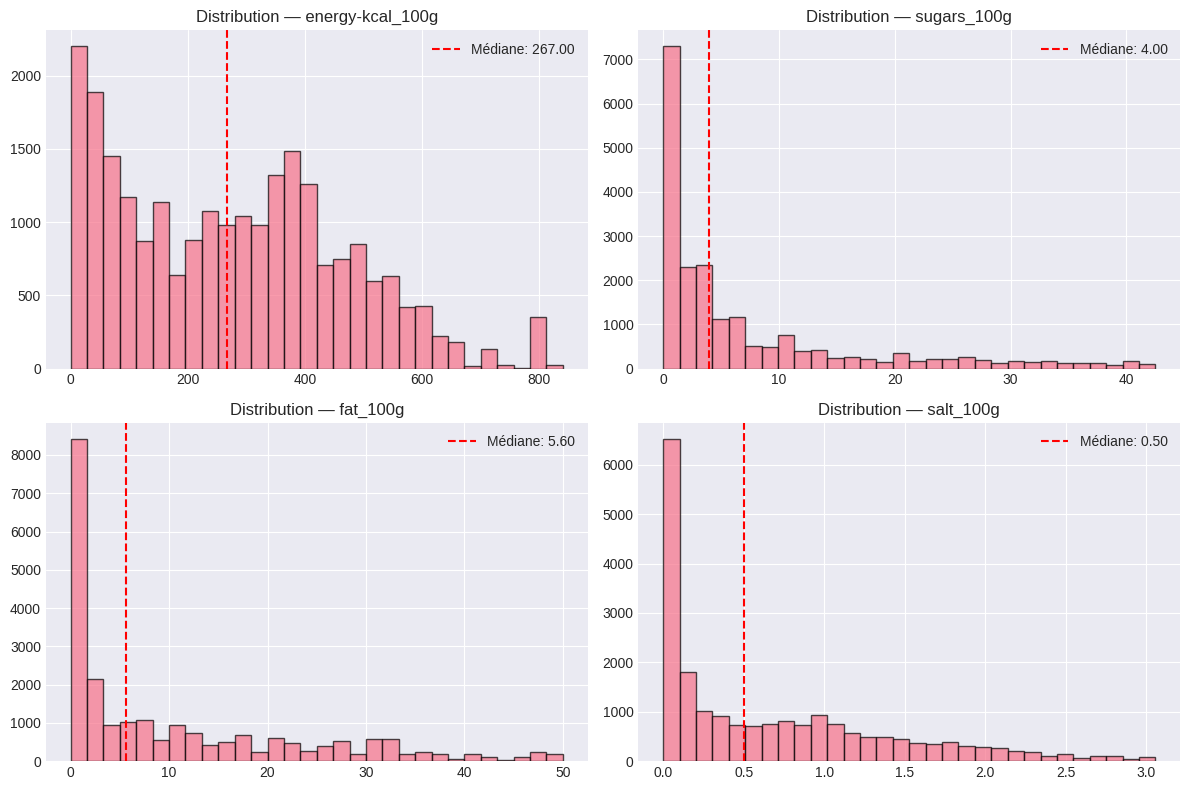


2️ Distribution des sucres par catégorie principale (top 10)


/tmp/ipython-input-2560729558.py:50: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(donnees_box, labels=labels)


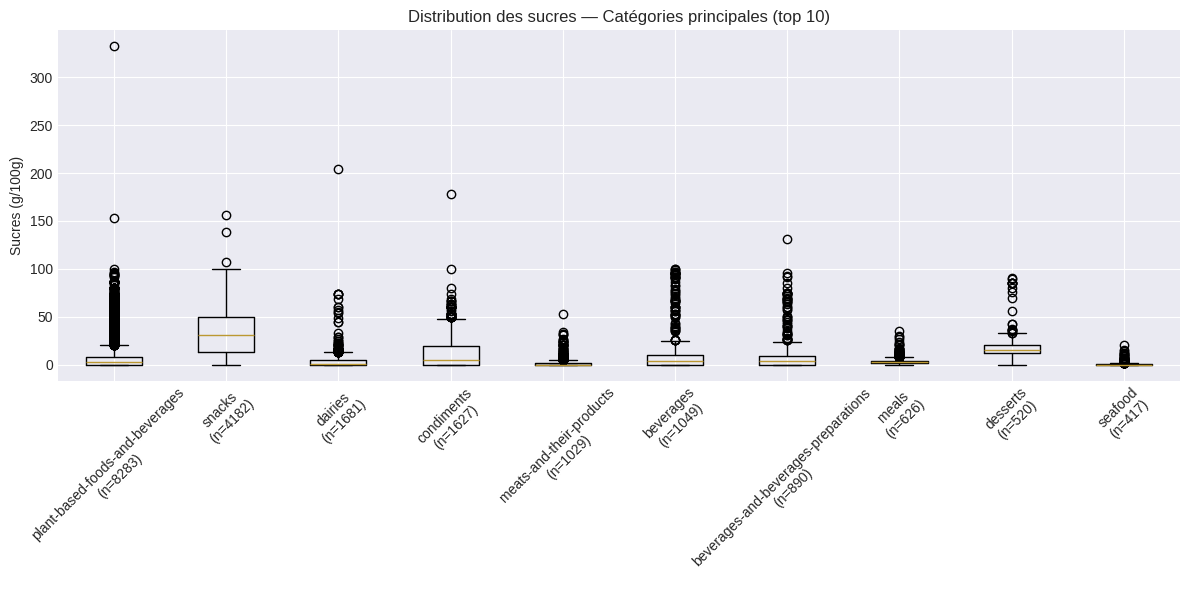

Top 5 catégories par moyenne de sucres (g/100g) :


,sugars_100g
categorie_principale,
snacks,32.35
desserts,17.19
condiments,11.43
beverages,8.59
plant-based-foods-and-beverages,8.49



3 Relation Nutri-Score vs nutriments


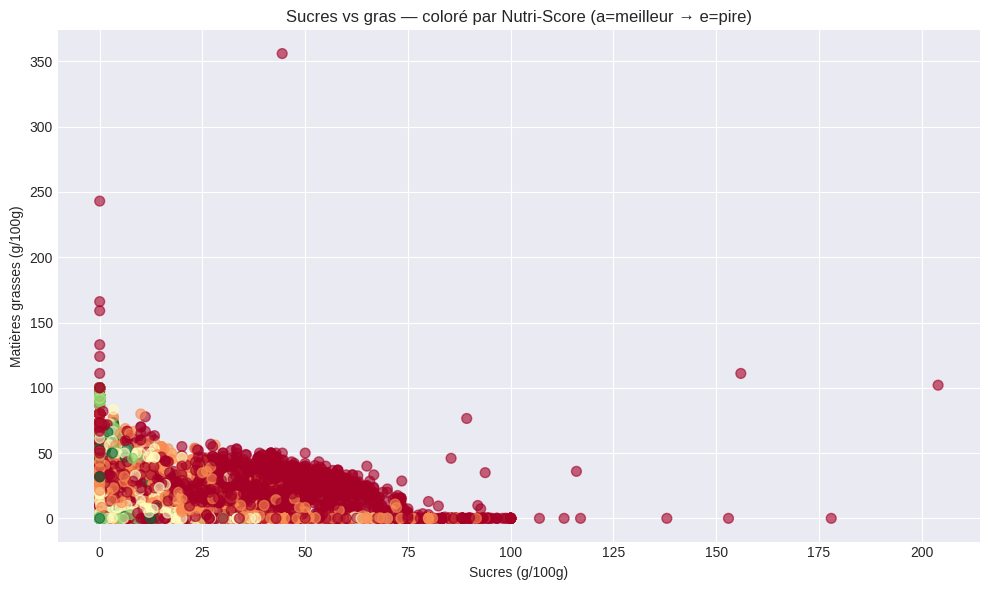

Corrélations (nutri_numeric: a=1 → e=5) :
• fat_100g: 0.219
• sugars_100g: 0.480
• salt_100g: 0.013
• energy_100g: 0.344
• energy-kcal_100g: 0.345


In [ ]:
print("\n1️ Comparaison des profils nutritionnels")
champs_nutrition = ["energy_100g", "energy-kcal_100g", "sugars_100g", "fat_100g", "salt_100g"]
disponibles = [c for c in champs_nutrition if c in df.columns]

if disponibles:
    display(df[disponibles].describe().round(2))

    a_tracer = [c for c in ["energy-kcal_100g", "sugars_100g", "fat_100g", "salt_100g"] if c in df.columns]
    if a_tracer:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        axes = axes.flatten()

        for i, col in enumerate(a_tracer[:4]):
            ax = axes[i]
            data = df[col].dropna()
            if len(data) == 0:
                ax.set_title(f"{col} (pas de données)")
                continue

            # Filtrage IQR pour améliorer la lisibilité du graphique
            q1, q3 = data.quantile(0.25), data.quantile(0.75)
            iqr = q3 - q1
            filtré = data[(data >= q1 - 1.5 * iqr) & (data <= q3 + 1.5 * iqr)]

            ax.hist(filtré, bins=30, edgecolor="black", alpha=0.7)
            ax.set_title(f"Distribution — {col}")
            ax.axvline(x=data.median(), color="red", linestyle="--", label=f"Médiane: {data.median():.2f}")
            ax.legend()

            plt.tight_layout()
        plt.show()
else:
    print(" Aucune donnée nutritionnelle disponible dans cet échantillon.")

# Objectif 2 : analyser les sucres par catégorie principale (top 10)
print("\n2️ Distribution des sucres par catégorie principale (top 10)")
if "categorie_principale" in df.columns and "sugars_100g" in df.columns:
    top_cat = df["categorie_principale"].value_counts().head(10).index

    donnees_box = []
    labels = []
    for cat in top_cat:
        sucres = df.loc[df["categorie_principale"] == cat, "sugars_100g"].dropna()
        if len(sucres) >= 5:
            donnees_box.append(sucres)
            labels.append(f"{cat}\n(n={len(sucres)})")

    if donnees_box:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.boxplot(donnees_box, labels=labels)
        ax.set_ylabel("Sucres (g/100g)")
        ax.set_title("Distribution des sucres — Catégories principales (top 10)")
        ax.tick_params(axis="x", rotation=45)
        plt.tight_layout()
        plt.show()

        print("Top 5 catégories par moyenne de sucres (g/100g) :")
        moyennes = (
            df[df["categorie_principale"].isin(top_cat)]
            .groupby("categorie_principale")["sugars_100g"]
            .mean()
            .sort_values(ascending=False)
            .head(5)
        )
        display(moyennes.round(2))
    else:
        print(" Données insuffisantes (il faut ≥ 5 produits par catégorie pour un boxplot).")
else:
    print(" Colonnes manquantes pour l'analyse par catégorie (categories_tags/categorie_principale + sugars_100g).")

# Objectif 3 : relation Nutri-Score vs nutriments (scatter + corrélations)
print("\n3 Relation Nutri-Score vs nutriments")
requis = {"nutriscore_grade", "sugars_100g", "fat_100g"}
if requis.issubset(df.columns):
    plot_data = df[["nutriscore_grade", "sugars_100g", "fat_100g"]].dropna()

    if len(plot_data) > 0:
        fig, ax = plt.subplots(figsize=(10, 6))

        ordre = ["a", "b", "c", "d", "e"]
        mapping = {g: i for i, g in enumerate(ordre)}
        codes = plot_data["nutriscore_grade"].map(mapping)

        ax.scatter(plot_data["sugars_100g"], plot_data["fat_100g"], c=codes, cmap="RdYlGn_r", alpha=0.6, s=50)
        ax.set_xlabel("Sucres (g/100g)")
        ax.set_ylabel("Matières grasses (g/100g)")
        ax.set_title("Sucres vs gras — coloré par Nutri-Score (a=meilleur → e=pire)")
        plt.tight_layout()
        plt.show()

        # Corrélations (a=1 ... e=5)
        df["nutri_numeric"] = df["nutriscore_grade"].map({"a": 1, "b": 2, "c": 3, "d": 4, "e": 5})

        print("Corrélations (nutri_numeric: a=1 → e=5) :")
        for nutr in ["fat_100g", "sugars_100g", "salt_100g", "energy_100g", "energy-kcal_100g"]:
            if nutr in df.columns:
                corr = df[["nutri_numeric", nutr]].dropna().corr().iloc[0, 1]
                print(f"• {nutr}: {corr:.3f}")
    else:
        print(" Pas assez de données après suppression des valeurs manquantes.")
else:
    print(" Colonnes manquantes pour l'analyse Nutri-Score vs nutriments.")


## 7) Dictionnaire de données (version simplifiée pour présentation)
# On garde volontairement une version courte : champs essentiels + champs assez remplis.


In [ ]:
print(" DICTIONNAIRE DE DONNÉES — Champs prioritaires")
print("=" * 80)

lignes_dict = []
for _, r in report_df.iterrows():
    champ = r["Champ"]
    present = champ in df.columns

    # Sélection : colonnes critiques + colonnes assez remplies (≥ 50%)
    if r["Priorité"] in ["CRITIQUE", "HAUTE"] or (present and r["Remplissage_%"] >= 50):
        if present and df[champ].notna().any():
            exemple = df[champ].dropna().iloc[0]
        else:
            exemple = "N/A"

        utilite = "ESSENTIEL" if ("nutri" in champ or "_100g" in champ or champ in ["categories_tags", "code"]) else "IMPORTANT"

        lignes_dict.append({
            "Champ": champ,
            "Description": r["Description"],
            "Type": r["Type"],
            "Exemple": (str(exemple)[:50] + "...") if len(str(exemple)) > 50 else str(exemple),
            "Remplissage": f"{r['Remplissage_%']:.1f}%",
            "Utilité_projet": utilite,
        })

dict_df = pd.DataFrame(lignes_dict)
display(dict_df.sort_values(["Utilité_projet", "Remplissage"], ascending=[True, False]))


 DICTIONNAIRE DE DONNÉES — Champs prioritaires


,Champ,Description,Type,Exemple,Remplissage,Utilité_projet
10,fat_100g,Matières grasses (g/100g),float64,2.29999995231628,99.8%,ESSENTIEL
14,proteins_100g,Protéines (g/100g),float64,4.30000019073486,99.8%,ESSENTIEL
7,energy_100g,Énergie (kJ/100g),float64,389.0,99.7%,ESSENTIEL
8,energy-kcal_100g,Énergie (kcal/100g),float64,93.0,99.6%,ESSENTIEL
9,sugars_100g,Sucres (g/100g),float64,2.20000004768372,96.5%,ESSENTIEL
11,saturated-fat_100g,Acides gras saturés (g/100g),float64,1.39999997615814,95.6%,ESSENTIEL
12,salt_100g,Sel (g/100g),float64,1.2,91.1%,ESSENTIEL
6,nutriscore_grade,Nutri-Score (A–E),object,c,85.1%,ESSENTIEL
13,fiber_100g,Fibres (g/100g),float64,1.10000002384186,70.2%,ESSENTIEL
0,code,Code-barres / identifiant produit (clé primair...,int64,264,100.0%,ESSENTIEL


## 8) Recommandations pour les transformations (Membre C) — Bronze → Silver
Objectif : nettoyage minimal, standardisation, déduplication et valeurs invalides → NULL.


In [ ]:
print(" RECOMMANDATIONS POUR LE MEMBRE C (Bronze → Silver)")
print("=" * 60)

recommandations = []

# Standardisation Nutri-Score (toujours pertinent)
if "nutriscore_grade" in df.columns:
    recommandations.append({
        "Problème": "Nutri-Score non standardisé (potentiel)",
        "Solution": "Mettre en minuscules + garder uniquement [a–e], sinon NULL",
        "Priorité": "HAUTE",
    })

# Valeurs invalides selon règles simples
for col, (mn, mx) in REGLES_VALIDITE.items():
    if col in df.columns:
        r, n = taux_valeurs_invalides(col, mn, mx)
        if n > 0:
            recommandations.append({
                "Problème": f"Valeurs invalides dans {col} ({n} lignes)",
                "Solution": f"Mettre à NULL les valeurs hors [{mn}, {mx}] en Silver",
                "Priorité": "MOYENNE" if r < 1 else "HAUTE",
            })

# Catégories manquantes
if "categories_tags" in df.columns:
    nb_vides = df["categories_tags"].isna().sum()
    if nb_vides > 0:
        recommandations.append({
            "Problème": f"{nb_vides} produits sans categories_tags",
            "Solution": "categorie_principale='uncategorized' (ne pas inférer agressivement au démarrage)",
            "Priorité": "HAUTE",
        })

# Doublons sur code
if "code" in df.columns:
    doublons = df["code"].astype(str).duplicated().sum()
    if doublons > 0:
        recommandations.append({
            "Problème": f"Doublons sur code: {doublons}",
            "Solution": "Dédupliquer sur code (garder la ligne la plus complète / la plus récente si dispo)",
            "Priorité": "HAUTE",
        })

if recommandations:
    rec_df = pd.DataFrame(recommandations)
    display(rec_df.sort_values(["Priorité", "Problème"]))
else:
    print(" Aucun problème majeur détecté via les contrôles actuels.")


 RECOMMANDATIONS POUR LE MEMBRE C (Bronze → Silver)


,Problème,Solution,Priorité
0,Nutri-Score non standardisé (potentiel),Mettre en minuscules + garder uniquement [a–e]...,HAUTE
4,Valeurs invalides dans energy-kcal_100g (48 li...,"Mettre à NULL les valeurs hors [0, 900] en Silver",MOYENNE
5,Valeurs invalides dans energy_100g (33 lignes),"Mettre à NULL les valeurs hors [0, 4000] en Si...",MOYENNE
2,Valeurs invalides dans fat_100g (9 lignes),"Mettre à NULL les valeurs hors [0, 100] en Silver",MOYENNE
3,Valeurs invalides dans salt_100g (68 lignes),"Mettre à NULL les valeurs hors [0, 50] en Silver",MOYENNE
1,Valeurs invalides dans sugars_100g (12 lignes),"Mettre à NULL les valeurs hors [0, 100] en Silver",MOYENNE


## 9) Export des résultats (pour le rapport / PPT)

In [ ]:

print(" EXPORT DES RÉSULTATS")

# Créer le dossier dashboard/reports/ si absent
Path("../dashboard/reports").mkdir(parents=True, exist_ok=True)

chemin_rapport = Path("../dashboard/reports/data_quality_report.csv")
chemin_dict = Path("../dashboard/reports/data_dictionary.csv")
chemin_resume = Path("../dashboard/reports/analysis_summary.txt")

report_df.to_csv(chemin_rapport, index=False, encoding="utf-8")
dict_df.to_csv(chemin_dict, index=False, encoding="utf-8")

with open(chemin_resume, "w", encoding="utf-8") as f:
    f.write("=== RÉSUMÉ — ANALYSE DE QUALITÉ  ===\n\n")
    f.write(f"Date: {pd.Timestamp.now()}\n")
    f.write(f"Taille échantillon: {len(df)} produits\n")
    f.write(f"Champs cruciaux analysés: {len(CHAMPS_CRUCIAUX)}\n\n")

    # Champs problématiques
    problemes = report_df[report_df["Priorité"].isin(["CRITIQUE", "HAUTE"])].sort_values("Remplissage_%")
    f.write("CHAMPS À SURVEILLER (CRITIQUE/HAUTE):\n")
    for _, r in problemes.iterrows():
        f.write(f"• {r['Champ']}: {r['Remplissage_%']:.1f}% rempli — {r['Description']}\n")

    # Disponibilité Nutri-Score
    f.write("\nDISPONIBILITÉ NUTRI-SCORE:\n")
    if "nutriscore_grade" in df.columns:
        f.write(f"• nutriscore_grade: {df['nutriscore_grade'].notna().mean()*100:.1f}% rempli\n")
    else:
        f.write("• nutriscore_grade: colonne absente\n")

    # Moyennes de quelques nutriments
    f.write("\nMOYENNES NUTRITIONNELLES (si disponibles):\n")
    for col in ["sugars_100g", "fat_100g", "salt_100g", "energy-kcal_100g"]:
        if col in df.columns:
            f.write(f"• {col}: moy={df[col].mean():.2f} (remplissage={df[col].notna().mean()*100:.1f}%)\n")

print(f"✓ Rapport de qualité: {chemin_rapport}")
print(f"✓ Dictionnaire: {chemin_dict}")
print(f"✓ Résumé: {chemin_resume}")
print("\n ANALYSE TERMINÉE")

 EXPORT DES RÉSULTATS
✓ Rapport de qualité: reports/data_quality_report.csv
✓ Dictionnaire: reports/data_dictionary.csv
✓ Résumé: reports/analysis_summary.txt

 ANALYSE TERMINÉE
